In [1]:
import os
from collections import OrderedDict
from collections import deque
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
result_dir = 'results/toy/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [4]:
try:
    from cbpy import net, plot, utils, dataset, train
except:
    import sys
    sys.path.append('../')
    from cbpy import net, plot, utils, dataset, train

In [9]:
def run_toy(toy_name,
            train_params,
            model_str,
            seed=1,
            onehot=False,
            act_layer=nn.ReLU(),
            init_mode=None,
            plot_n_weight=[4, 4],
            save_best_loss_model=False,
            result_dir=None,
            record_weight=False,
            whole_weight=False,
            save_result=True):
    
    zs = np.repeat(np.asarray(train_params['zs']), 2)
    cbp_epoch = train_params['cbp_epoch']
    max_epoch = train_params['max_epoch']
    cbp_lr = train_params['cbp_lr']
    bp_lr = train_params['bp_lr']
    beta = train_params['beta']
    record_acc = train_params['record_acc']

    utils.set_random_seed(seed)
    trainloader = dataset.create_toy_dataloader(toy_name)
    loss_func = nn.MSELoss() if onehot else nn.CrossEntropyLoss()
    in_D, hid_D, out_D = [int(n) for n in model_str.split('-')]
    model = net.MLPS([in_D, hid_D, out_D], act_layer=act_layer, init_mode=init_mode)

    algo = 'CBP' if cbp_epoch > 0 else 'BP'
    loss_func_str = 'MSE' if onehot else 'CE'
    model_str = '-'.join([str(i) for i in [in_D, hid_D, out_D]])
    seed_str = str(seed)
    init_str = str(init_mode)
    if isinstance(act_layer, nn.ReLU):
        act_str = 'relu'
    elif isinstance(act_layer, nn.Sigmoid):
        act_str = 'sig'
    else:
        raise ValueError(f'Unrecognized act_layer: {act_layer}, must be ReLU or Sigmoid')

    if result_dir is None:
        result_dir = f'results/toy/{toy_name}'

    logdir = f'{result_dir}/{model_str}/{algo}_{loss_func_str}_{act_str}_init{init_str}_seed{seed_str}/'
    if not os.path.exists(logdir):
        tl_list, ta_list, ws_list, os_list = train.train_with_chaos(
            model,
            trainloader,
            trainloader,
            loss_func,
            zs=zs,
            cbp_epoch=cbp_epoch,
            max_epoch=max_epoch,
            cbp_lr=cbp_lr,
            bp_lr=bp_lr,
            beta=beta,
            record_weight=record_weight,
            logdir=logdir,
            record_acc=record_acc,
            onehot=onehot,
            save_best_loss_model=save_best_loss_model,
            whole_weight=whole_weight
        )

        if not save_result:
            logdir = None

        if record_weight:
            if whole_weight:
                ws = np.array([w['model.0.weight'].flatten() for w in ws_list])
                ws2 = np.array([w['model.1.weight'].flatten() for w in ws_list])
            else:
                ws = np.array([w[0].flatten() for w in ws_list])
                ws2 = np.array([w[1].flatten() for w in ws_list])

            n1 = min(ws.shape[1], plot_n_weight[0])
            n2 = min(ws2.shape[1], plot_n_weight[1])
            plot.plot_w_traj(ws, first=n1, save_prefix=logdir, suffix='fc1_weight',
                             suptitle=f'{algo} layer1 weight')
            plot.plot_w_traj(ws2, first=n2, save_prefix=logdir, suffix='fc2_weight',
                             suptitle=f'{algo} layer2 weight')

        plot.plot_loss_acc(tl_list, ta_list, log_scale=True, save_prefix=logdir,
                           acc_train=True, suptitle=f'{algo} loss and acc')

        if logdir is not None:
            np.savetxt(logdir + 'loss.txt', np.asarray(tl_list))
            np.savetxt(logdir + 'acc.txt', np.asarray(ta_list))

            result = [algo, loss_func_str, model_str, seed_str, init_str, act_str,
                      min(tl_list), tl_list[-1], max(ta_list), ta_list[-1]]
            np.savetxt(logdir + 'result.txt', np.asarray(result).reshape(1, -1), fmt='%s')

In [6]:
def get_default_toy_params():
    default_toy_params = {
        'digits': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 1000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.99,
                'record_acc': [0.96, 0.98]
            },
            'CBP': {
                'zs': [3., 1.],
                'cbp_epoch': 150,
                'max_epoch': 1000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.99,
                'record_acc': [0.96, 0.98]}
        },
        'wine': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 1000,
                'cbp_lr': 0.2,
                'bp_lr': 0.2,
                'beta': 0.99,
                'record_acc': [0.98, 1.]
            },
            'CBP': {
                'zs': [3., 1.],
                'cbp_epoch': 100,
                'max_epoch': 1000,
                'cbp_lr': 0.2,
                'bp_lr': 0.2,
                'beta': 0.99,
                'record_acc': [0.98, 1.]}
        },
        'twonorm': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 300,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.98,
                'record_acc': [0.95, 0.97]
            },
            'CBP': {
                'zs': [5., 1.],
                'cbp_epoch': 100,
                'max_epoch': 300,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.98,
                'record_acc': [0.95, 0.97]}
        },
        'breast': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 2000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.995,
                'record_acc': [0.96, 0.97]
            },
            'CBP': {
                'zs': [9., 3.],
                'cbp_epoch': 200,
                'max_epoch': 2000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.995,
                'record_acc': [0.96, 0.97]}
        },
        'blood': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 2000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.995,
                'record_acc': [0.77, 0.78]
            },
            'CBP': {
                'zs': [12., 2.],
                'cbp_epoch': 200,
                'max_epoch': 2000,
                'cbp_lr': 0.1,
                'bp_lr': 0.1,
                'beta': 0.995,
                'record_acc': [0.77, 0.78]}
        },
        'titanic': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 2000,
                'cbp_lr': 0.2,
                'bp_lr': 0.2,
                'beta': 0.995,
                'record_acc': [0.78, 0.79]
            },
            'CBP': {
                'zs': [6., 3.],
                'cbp_epoch': 200,
                'max_epoch': 2000,
                'cbp_lr': 0.2,
                'bp_lr': 0.2,
                'beta': 0.995,
                'record_acc': [0.78, 0.79]}
        },
        'iris': {
            'BP': {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': 3000,
                'cbp_lr': 0.5,
                'bp_lr': 0.5,
                'beta': 0.995,
                'record_acc': [0.98, 1.]
            },
            'CBP': {
                'zs': [9., 3.],
                'cbp_epoch': 200,
                'max_epoch': 3000,
                'cbp_lr': 0.5,
                'bp_lr': 0.5,
                'beta': 0.995,
                'record_acc': [0.98, 1.]}
        }
    }
    return default_toy_params


def dump_default_toy_params(toy_params=None,
                            json_file="toy_params.json"):
    if toy_params is None:
        toy_params = get_default_toy_params()

    with open(json_file, "w") as f:
        f.write(json.dumps(toy_params, ensure_ascii=False,
                           indent=4, separators=(',', ':')))


def get_default_plot_params(name):
    if name == 'digits':
        acc1, acc2 = 96, 98
        max_y = 30
        loss_lim = [.02, .11]
        acc_lim = [.975, 1.]
    elif name == 'wine':
        acc1, acc2 = 98, 100
        max_y = 4
        loss_lim = [.004, .018]
        acc_lim = [.9, 1.01]
    elif name == 'twonorm':
        acc1, acc2 = 95, 97
        max_y = 40
        loss_lim = [.1, .5]
        acc_lim = [.95, .98]
    elif name == 'breast':
        acc1, acc2 = 96, 97
        max_y = 20
        loss_lim = [.085, .105]
        acc_lim = [.96, .975]
    elif name == 'blood':
        acc1, acc2 = 77, 78
        max_y = 20
        loss_lim = [0.46, .475]
        acc_lim = [.76, .8]
    elif name == 'titanic':
        acc1, acc2 = 78, 79
        max_y = 60
        loss_lim = [.483, .498]
        acc_lim = [.775, .792]
    elif name == 'iris':
        acc1, acc2 = 98, 100
        max_y = 8
        loss_lim = [.01, .05]
        acc_lim = [.97, 1.0]
    else:
        raise ValueError(f'Unrecognized dataset name: {name}')
    return acc1, acc2, loss_lim, acc_lim, max_y

In [7]:
def run_toy_example(name,
                    seeds,
                    model,
                    train=True,
                    analysis=True,
                    **params):
    assert name in ['digits', 'wine', 'twonorm', 'breast', 'blood', 'titanic', 'iris']
    result_dir = f'results/toy/{name}'

    if train:
        toy_params = get_default_toy_params()
        for lm in ['BP', 'CBP']:
            train_params = toy_params[name][lm]
            for seed in seeds:
                run_toy(name, train_params, model_str=model, seed=seed, result_dir=result_dir, **params)

    if analysis:
        acc1, acc2, loss_lim, acc_lim, max_y = get_default_plot_params(name)
        columns = ['method', 'loss_func', 'net', 'seed', 'init', 'act_func',
                   'train loss', 'train loss (last)', 'train acc', 'train acc (last)']
        save_prefix = f'{result_dir}/{model}/'

        results = []
        train_loss = []
        train_acc = []
        for lm in ['BP', 'CBP']:
            for seed in seeds:
                dir = f'{save_prefix}{lm}_CE_relu_initNone_seed{seed}/'
                results.append(pd.read_csv(dir + 'result.txt', sep='\s+', names=columns))
                train_loss.append(np.loadtxt(dir + 'loss.txt'))
                train_acc.append(np.loadtxt(dir + 'acc.txt'))
        df = pd.concat(results)
        df.to_csv(f'{save_prefix}results.txt', sep=',', index=False)
        plot.plot_compare_loss_acc(df, save_prefix=save_prefix, acc_train=True, 
                                   ylabels=['minimal loss', 'maximal accuracy'])

        if len(seeds) > 1:
            sum_df = utils.results_summary(df, acc_train=True)
            sum_df.to_csv(f'{save_prefix}results_summary.txt', sep=',', index=False)

        train_loss = np.asarray(train_loss).T
        train_acc = np.asarray(train_acc).T
        np.savetxt(f'{save_prefix}loss.txt', train_loss)
        np.savetxt(f'{save_prefix}acc.txt', train_acc)
        plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                               acc1=acc1, acc2=acc2, alpha=1, acc_train=True)
        plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                               acc1=acc1, acc2=acc2, loss_lim=loss_lim,
                               acc_lim=acc_lim, alpha=1, acc_train=True)

        time_records = []
        for lm in ['BP', 'CBP']:
            for seed in seeds:
                dir = f'{save_prefix}{lm}_CE_relu_initNone_seed{seed}/'
                file = open(dir + 'train.log', 'r')
                output = deque(file, 5)
                l = list(output)
                train_time = float(l[0].split(' ')[-2])
                time_record = [lm, seed, train_time]
                for i in [3, 4]:
                    t = l[i].split(' ')[-2]
                    try:
                        int(t)
                        t = train_time # using train time instead if don't reach
                    except:
                        t = float(t)
                    time_record.append(t)
                time_records.append(time_record)
                file.close()
        df = pd.DataFrame(time_records, columns=[
            'method', 'seed', 'train time (s)', f'time for {acc1}% (s)', f'time for {acc2}% (s)'])
        plot.plot_train_time(df, acc1=acc1, acc2=acc2, max_y=max_y, save_prefix=save_prefix)
        df.to_csv(f'{save_prefix}times.txt', sep=',', index=False)

        if len(seeds) > 1:
            sum_df = utils.times_summary(df)
            sum_df.to_csv(f'{save_prefix}times_summary.txt', sep=',', index=False)

In [10]:
# training example
run_toy_example('digits', [7], model='64-129-10', train=True, analysis=True,
                record_weight=True, save_result=True)

--------------------------------------------------
Train Params:
  zs: [None None]
  beta: 0.99
  cbp_epoch: 0
  max_epoch: 1000
  cbp_lr: 0.1
  bp_lr: 0.1
  bp_momentum: 0
  bp_adam: False
  logfile: results/toy/digits/64-129-10/BP_CE_relu_initNone_seed7/train.log
--------------------------------------------------
==================== start training ====================
EPOCH:     1 | BP | train loss: 2.2897 | test acc: 0.0890
EPOCH:     2 | BP | train loss: 2.2801 | test acc: 0.1208
EPOCH:     3 | BP | train loss: 2.2706 | test acc: 0.1553
EPOCH:     4 | BP | train loss: 2.2613 | test acc: 0.1920
EPOCH:     5 | BP | train loss: 2.2520 | test acc: 0.2287
EPOCH:     6 | BP | train loss: 2.2428 | test acc: 0.2649
EPOCH:     7 | BP | train loss: 2.2335 | test acc: 0.3016
EPOCH:     8 | BP | train loss: 2.2243 | test acc: 0.3372
EPOCH:     9 | BP | train loss: 2.2150 | test acc: 0.3678
EPOCH:    10 | BP | train loss: 2.2057 | test acc: 0.3984
EPOCH:    11 | BP | train loss: 2.1962 | test 

EPOCH:   136 | BP | train loss: 0.6283 | test acc: 0.9160
EPOCH:   137 | BP | train loss: 0.6226 | test acc: 0.9160
EPOCH:   138 | BP | train loss: 0.6171 | test acc: 0.9160
EPOCH:   139 | BP | train loss: 0.6117 | test acc: 0.9165
EPOCH:   140 | BP | train loss: 0.6063 | test acc: 0.9165
EPOCH:   141 | BP | train loss: 0.6011 | test acc: 0.9182
EPOCH:   142 | BP | train loss: 0.5959 | test acc: 0.9188
EPOCH:   143 | BP | train loss: 0.5908 | test acc: 0.9193
EPOCH:   144 | BP | train loss: 0.5858 | test acc: 0.9193
EPOCH:   145 | BP | train loss: 0.5809 | test acc: 0.9193
EPOCH:   146 | BP | train loss: 0.5761 | test acc: 0.9193
EPOCH:   147 | BP | train loss: 0.5713 | test acc: 0.9188
EPOCH:   148 | BP | train loss: 0.5667 | test acc: 0.9193
EPOCH:   149 | BP | train loss: 0.5621 | test acc: 0.9193
EPOCH:   150 | BP | train loss: 0.5575 | test acc: 0.9193
EPOCH:   151 | BP | train loss: 0.5531 | test acc: 0.9193
EPOCH:   152 | BP | train loss: 0.5487 | test acc: 0.9204
EPOCH:   153 |

EPOCH:   278 | BP | train loss: 0.2819 | test acc: 0.9482
EPOCH:   279 | BP | train loss: 0.2808 | test acc: 0.9482
EPOCH:   280 | BP | train loss: 0.2799 | test acc: 0.9482
EPOCH:   281 | BP | train loss: 0.2789 | test acc: 0.9482
EPOCH:   282 | BP | train loss: 0.2779 | test acc: 0.9482
EPOCH:   283 | BP | train loss: 0.2769 | test acc: 0.9482
EPOCH:   284 | BP | train loss: 0.2760 | test acc: 0.9482
EPOCH:   285 | BP | train loss: 0.2750 | test acc: 0.9482
EPOCH:   286 | BP | train loss: 0.2741 | test acc: 0.9488
EPOCH:   287 | BP | train loss: 0.2731 | test acc: 0.9488
EPOCH:   288 | BP | train loss: 0.2722 | test acc: 0.9488
EPOCH:   289 | BP | train loss: 0.2713 | test acc: 0.9488
EPOCH:   290 | BP | train loss: 0.2703 | test acc: 0.9488
EPOCH:   291 | BP | train loss: 0.2694 | test acc: 0.9488
EPOCH:   292 | BP | train loss: 0.2685 | test acc: 0.9488
EPOCH:   293 | BP | train loss: 0.2676 | test acc: 0.9488
EPOCH:   294 | BP | train loss: 0.2667 | test acc: 0.9488
EPOCH:   295 |

EPOCH:   420 | BP | train loss: 0.1927 | test acc: 0.9633
EPOCH:   421 | BP | train loss: 0.1923 | test acc: 0.9633
EPOCH:   422 | BP | train loss: 0.1920 | test acc: 0.9633
EPOCH:   423 | BP | train loss: 0.1916 | test acc: 0.9633
EPOCH:   424 | BP | train loss: 0.1912 | test acc: 0.9633
EPOCH:   425 | BP | train loss: 0.1908 | test acc: 0.9633
EPOCH:   426 | BP | train loss: 0.1904 | test acc: 0.9633
EPOCH:   427 | BP | train loss: 0.1901 | test acc: 0.9633
EPOCH:   428 | BP | train loss: 0.1897 | test acc: 0.9633
EPOCH:   429 | BP | train loss: 0.1893 | test acc: 0.9633
EPOCH:   430 | BP | train loss: 0.1889 | test acc: 0.9633
EPOCH:   431 | BP | train loss: 0.1886 | test acc: 0.9633
EPOCH:   432 | BP | train loss: 0.1882 | test acc: 0.9644
EPOCH:   433 | BP | train loss: 0.1878 | test acc: 0.9644
EPOCH:   434 | BP | train loss: 0.1875 | test acc: 0.9644
EPOCH:   435 | BP | train loss: 0.1871 | test acc: 0.9649
EPOCH:   436 | BP | train loss: 0.1867 | test acc: 0.9649
EPOCH:   437 |

EPOCH:   562 | BP | train loss: 0.1522 | test acc: 0.9722
EPOCH:   563 | BP | train loss: 0.1520 | test acc: 0.9722
EPOCH:   564 | BP | train loss: 0.1518 | test acc: 0.9722
EPOCH:   565 | BP | train loss: 0.1516 | test acc: 0.9722
EPOCH:   566 | BP | train loss: 0.1514 | test acc: 0.9722
EPOCH:   567 | BP | train loss: 0.1512 | test acc: 0.9722
EPOCH:   568 | BP | train loss: 0.1510 | test acc: 0.9722
EPOCH:   569 | BP | train loss: 0.1508 | test acc: 0.9722
EPOCH:   570 | BP | train loss: 0.1506 | test acc: 0.9722
EPOCH:   571 | BP | train loss: 0.1504 | test acc: 0.9722
EPOCH:   572 | BP | train loss: 0.1502 | test acc: 0.9722
EPOCH:   573 | BP | train loss: 0.1500 | test acc: 0.9722
EPOCH:   574 | BP | train loss: 0.1498 | test acc: 0.9722
EPOCH:   575 | BP | train loss: 0.1496 | test acc: 0.9722
EPOCH:   576 | BP | train loss: 0.1494 | test acc: 0.9722
EPOCH:   577 | BP | train loss: 0.1492 | test acc: 0.9722
EPOCH:   578 | BP | train loss: 0.1490 | test acc: 0.9722
EPOCH:   579 |

EPOCH:   704 | BP | train loss: 0.1284 | test acc: 0.9750
EPOCH:   705 | BP | train loss: 0.1282 | test acc: 0.9750
EPOCH:   706 | BP | train loss: 0.1281 | test acc: 0.9750
EPOCH:   707 | BP | train loss: 0.1280 | test acc: 0.9750
EPOCH:   708 | BP | train loss: 0.1278 | test acc: 0.9750
EPOCH:   709 | BP | train loss: 0.1277 | test acc: 0.9750
EPOCH:   710 | BP | train loss: 0.1276 | test acc: 0.9750
EPOCH:   711 | BP | train loss: 0.1274 | test acc: 0.9750
EPOCH:   712 | BP | train loss: 0.1273 | test acc: 0.9750
EPOCH:   713 | BP | train loss: 0.1272 | test acc: 0.9750
EPOCH:   714 | BP | train loss: 0.1270 | test acc: 0.9750
EPOCH:   715 | BP | train loss: 0.1269 | test acc: 0.9755
EPOCH:   716 | BP | train loss: 0.1268 | test acc: 0.9755
EPOCH:   717 | BP | train loss: 0.1266 | test acc: 0.9755
EPOCH:   718 | BP | train loss: 0.1265 | test acc: 0.9755
EPOCH:   719 | BP | train loss: 0.1264 | test acc: 0.9755
EPOCH:   720 | BP | train loss: 0.1263 | test acc: 0.9755
EPOCH:   721 |

EPOCH:   846 | BP | train loss: 0.1122 | test acc: 0.9789
EPOCH:   847 | BP | train loss: 0.1121 | test acc: 0.9789
EPOCH:   848 | BP | train loss: 0.1120 | test acc: 0.9789
EPOCH:   849 | BP | train loss: 0.1119 | test acc: 0.9789
EPOCH:   850 | BP | train loss: 0.1118 | test acc: 0.9789
EPOCH:   851 | BP | train loss: 0.1117 | test acc: 0.9789
EPOCH:   852 | BP | train loss: 0.1116 | test acc: 0.9789
EPOCH:   853 | BP | train loss: 0.1115 | test acc: 0.9789
EPOCH:   854 | BP | train loss: 0.1114 | test acc: 0.9794
EPOCH:   855 | BP | train loss: 0.1113 | test acc: 0.9794
EPOCH:   856 | BP | train loss: 0.1112 | test acc: 0.9794
EPOCH:   857 | BP | train loss: 0.1111 | test acc: 0.9794
EPOCH:   858 | BP | train loss: 0.1110 | test acc: 0.9794
EPOCH:   859 | BP | train loss: 0.1109 | test acc: 0.9794
EPOCH:   860 | BP | train loss: 0.1108 | test acc: 0.9800
EPOCH:   861 | BP | train loss: 0.1107 | test acc: 0.9800
EPOCH:   862 | BP | train loss: 0.1106 | test acc: 0.9800
EPOCH:   863 |

EPOCH:   988 | BP | train loss: 0.1001 | test acc: 0.9816
EPOCH:   989 | BP | train loss: 0.1001 | test acc: 0.9816
EPOCH:   990 | BP | train loss: 0.1000 | test acc: 0.9816
EPOCH:   991 | BP | train loss: 0.0999 | test acc: 0.9816
EPOCH:   992 | BP | train loss: 0.0998 | test acc: 0.9816
EPOCH:   993 | BP | train loss: 0.0998 | test acc: 0.9816
EPOCH:   994 | BP | train loss: 0.0997 | test acc: 0.9816
EPOCH:   995 | BP | train loss: 0.0996 | test acc: 0.9816
EPOCH:   996 | BP | train loss: 0.0995 | test acc: 0.9816
EPOCH:   997 | BP | train loss: 0.0995 | test acc: 0.9816
EPOCH:   998 | BP | train loss: 0.0994 | test acc: 0.9816
EPOCH:   999 | BP | train loss: 0.0993 | test acc: 0.9816
EPOCH:  1000 | BP | train loss: 0.0992 | test acc: 0.9816
==================== finish training ====================
  training time: 26.35 s
  reach best train loss 0.0992 at epoch 1000
  reach best test acc 0.9816 at epoch 928
  reach 0.96 acc in 10.45 s
  reach 0.98 acc in 23.02 s
--------------------

EPOCH:   114 | CBP | train loss: 32.7886 | test acc: 0.4240
EPOCH:   115 | CBP | train loss: 23.2754 | test acc: 0.3239
EPOCH:   116 | CBP | train loss: 32.6965 | test acc: 0.2538
EPOCH:   117 | CBP | train loss: 46.5722 | test acc: 0.2782
EPOCH:   118 | CBP | train loss: 46.1337 | test acc: 0.3612
EPOCH:   119 | CBP | train loss: 30.7429 | test acc: 0.3322
EPOCH:   120 | CBP | train loss: 33.0068 | test acc: 0.4441
EPOCH:   121 | CBP | train loss: 17.3806 | test acc: 0.3495
EPOCH:   122 | CBP | train loss: 28.1170 | test acc: 0.3439
EPOCH:   123 | CBP | train loss: 18.8208 | test acc: 0.5298
EPOCH:   124 | CBP | train loss: 22.6482 | test acc: 0.3984
EPOCH:   125 | CBP | train loss: 20.8653 | test acc: 0.5743
EPOCH:   126 | CBP | train loss: 13.5063 | test acc: 0.4424
EPOCH:   127 | CBP | train loss: 15.4743 | test acc: 0.4446
EPOCH:   128 | CBP | train loss: 19.4557 | test acc: 0.6427
EPOCH:   129 | CBP | train loss: 8.5149 | test acc: 0.4958
EPOCH:   130 | CBP | train loss: 16.9734 

EPOCH:   255 | BP | train loss: 0.3285 | test acc: 0.9555
EPOCH:   256 | BP | train loss: 0.3263 | test acc: 0.9555
EPOCH:   257 | BP | train loss: 0.3242 | test acc: 0.9555
EPOCH:   258 | BP | train loss: 0.3221 | test acc: 0.9566
EPOCH:   259 | BP | train loss: 0.3200 | test acc: 0.9566
EPOCH:   260 | BP | train loss: 0.3180 | test acc: 0.9572
EPOCH:   261 | BP | train loss: 0.3160 | test acc: 0.9572
EPOCH:   262 | BP | train loss: 0.3140 | test acc: 0.9572
EPOCH:   263 | BP | train loss: 0.3121 | test acc: 0.9572
EPOCH:   264 | BP | train loss: 0.3101 | test acc: 0.9572
EPOCH:   265 | BP | train loss: 0.3081 | test acc: 0.9572
EPOCH:   266 | BP | train loss: 0.3062 | test acc: 0.9566
EPOCH:   267 | BP | train loss: 0.3042 | test acc: 0.9566
EPOCH:   268 | BP | train loss: 0.3023 | test acc: 0.9566
EPOCH:   269 | BP | train loss: 0.3004 | test acc: 0.9566
EPOCH:   270 | BP | train loss: 0.2985 | test acc: 0.9572
EPOCH:   271 | BP | train loss: 0.2967 | test acc: 0.9572
EPOCH:   272 |

EPOCH:   397 | BP | train loss: 0.1567 | test acc: 0.9738
EPOCH:   398 | BP | train loss: 0.1560 | test acc: 0.9738
EPOCH:   399 | BP | train loss: 0.1553 | test acc: 0.9738
EPOCH:   400 | BP | train loss: 0.1547 | test acc: 0.9738
EPOCH:   401 | BP | train loss: 0.1540 | test acc: 0.9738
EPOCH:   402 | BP | train loss: 0.1533 | test acc: 0.9738
EPOCH:   403 | BP | train loss: 0.1526 | test acc: 0.9750
EPOCH:   404 | BP | train loss: 0.1519 | test acc: 0.9750
EPOCH:   405 | BP | train loss: 0.1513 | test acc: 0.9750
EPOCH:   406 | BP | train loss: 0.1506 | test acc: 0.9750
EPOCH:   407 | BP | train loss: 0.1500 | test acc: 0.9750
EPOCH:   408 | BP | train loss: 0.1493 | test acc: 0.9750
EPOCH:   409 | BP | train loss: 0.1487 | test acc: 0.9750
EPOCH:   410 | BP | train loss: 0.1480 | test acc: 0.9750
EPOCH:   411 | BP | train loss: 0.1474 | test acc: 0.9750
EPOCH:   412 | BP | train loss: 0.1468 | test acc: 0.9750
EPOCH:   413 | BP | train loss: 0.1462 | test acc: 0.9755
EPOCH:   414 |

EPOCH:   539 | BP | train loss: 0.0908 | test acc: 0.9816
EPOCH:   540 | BP | train loss: 0.0905 | test acc: 0.9816
EPOCH:   541 | BP | train loss: 0.0901 | test acc: 0.9816
EPOCH:   542 | BP | train loss: 0.0898 | test acc: 0.9816
EPOCH:   543 | BP | train loss: 0.0895 | test acc: 0.9816
EPOCH:   544 | BP | train loss: 0.0892 | test acc: 0.9816
EPOCH:   545 | BP | train loss: 0.0888 | test acc: 0.9816
EPOCH:   546 | BP | train loss: 0.0885 | test acc: 0.9816
EPOCH:   547 | BP | train loss: 0.0882 | test acc: 0.9816
EPOCH:   548 | BP | train loss: 0.0879 | test acc: 0.9816
EPOCH:   549 | BP | train loss: 0.0875 | test acc: 0.9816
EPOCH:   550 | BP | train loss: 0.0872 | test acc: 0.9816
EPOCH:   551 | BP | train loss: 0.0869 | test acc: 0.9816
EPOCH:   552 | BP | train loss: 0.0866 | test acc: 0.9816
EPOCH:   553 | BP | train loss: 0.0863 | test acc: 0.9816
EPOCH:   554 | BP | train loss: 0.0859 | test acc: 0.9816
EPOCH:   555 | BP | train loss: 0.0856 | test acc: 0.9816
EPOCH:   556 |

EPOCH:   681 | BP | train loss: 0.0554 | test acc: 0.9905
EPOCH:   682 | BP | train loss: 0.0553 | test acc: 0.9905
EPOCH:   683 | BP | train loss: 0.0551 | test acc: 0.9905
EPOCH:   684 | BP | train loss: 0.0549 | test acc: 0.9905
EPOCH:   685 | BP | train loss: 0.0548 | test acc: 0.9905
EPOCH:   686 | BP | train loss: 0.0546 | test acc: 0.9905
EPOCH:   687 | BP | train loss: 0.0544 | test acc: 0.9905
EPOCH:   688 | BP | train loss: 0.0543 | test acc: 0.9905
EPOCH:   689 | BP | train loss: 0.0541 | test acc: 0.9905
EPOCH:   690 | BP | train loss: 0.0539 | test acc: 0.9905
EPOCH:   691 | BP | train loss: 0.0538 | test acc: 0.9905
EPOCH:   692 | BP | train loss: 0.0536 | test acc: 0.9905
EPOCH:   693 | BP | train loss: 0.0535 | test acc: 0.9905
EPOCH:   694 | BP | train loss: 0.0533 | test acc: 0.9905
EPOCH:   695 | BP | train loss: 0.0531 | test acc: 0.9905
EPOCH:   696 | BP | train loss: 0.0530 | test acc: 0.9905
EPOCH:   697 | BP | train loss: 0.0528 | test acc: 0.9905
EPOCH:   698 |

EPOCH:   823 | BP | train loss: 0.0389 | test acc: 0.9950
EPOCH:   824 | BP | train loss: 0.0388 | test acc: 0.9950
EPOCH:   825 | BP | train loss: 0.0387 | test acc: 0.9950
EPOCH:   826 | BP | train loss: 0.0386 | test acc: 0.9955
EPOCH:   827 | BP | train loss: 0.0386 | test acc: 0.9955
EPOCH:   828 | BP | train loss: 0.0385 | test acc: 0.9955
EPOCH:   829 | BP | train loss: 0.0384 | test acc: 0.9955
EPOCH:   830 | BP | train loss: 0.0383 | test acc: 0.9955
EPOCH:   831 | BP | train loss: 0.0382 | test acc: 0.9955
EPOCH:   832 | BP | train loss: 0.0381 | test acc: 0.9955
EPOCH:   833 | BP | train loss: 0.0381 | test acc: 0.9955
EPOCH:   834 | BP | train loss: 0.0380 | test acc: 0.9955
EPOCH:   835 | BP | train loss: 0.0379 | test acc: 0.9955
EPOCH:   836 | BP | train loss: 0.0378 | test acc: 0.9955
EPOCH:   837 | BP | train loss: 0.0377 | test acc: 0.9955
EPOCH:   838 | BP | train loss: 0.0377 | test acc: 0.9955
EPOCH:   839 | BP | train loss: 0.0376 | test acc: 0.9955
EPOCH:   840 |

EPOCH:   965 | BP | train loss: 0.0293 | test acc: 0.9972
EPOCH:   966 | BP | train loss: 0.0293 | test acc: 0.9972
EPOCH:   967 | BP | train loss: 0.0292 | test acc: 0.9972
EPOCH:   968 | BP | train loss: 0.0292 | test acc: 0.9972
EPOCH:   969 | BP | train loss: 0.0291 | test acc: 0.9972
EPOCH:   970 | BP | train loss: 0.0291 | test acc: 0.9972
EPOCH:   971 | BP | train loss: 0.0290 | test acc: 0.9972
EPOCH:   972 | BP | train loss: 0.0289 | test acc: 0.9972
EPOCH:   973 | BP | train loss: 0.0289 | test acc: 0.9972
EPOCH:   974 | BP | train loss: 0.0288 | test acc: 0.9972
EPOCH:   975 | BP | train loss: 0.0288 | test acc: 0.9972
EPOCH:   976 | BP | train loss: 0.0287 | test acc: 0.9972
EPOCH:   977 | BP | train loss: 0.0287 | test acc: 0.9972
EPOCH:   978 | BP | train loss: 0.0286 | test acc: 0.9972
EPOCH:   979 | BP | train loss: 0.0286 | test acc: 0.9972
EPOCH:   980 | BP | train loss: 0.0285 | test acc: 0.9972
EPOCH:   981 | BP | train loss: 0.0285 | test acc: 0.9972
EPOCH:   982 |

> example of the learning curves of the weights of BP and CBP 
![cbp](results/toy/digits/64-129-10/BP_CE_relu_initNone_seed7/fc1_weight.png)
![cbp](results/toy/digits/64-129-10/CBP_CE_relu_initNone_seed7/fc1_weight.png)

> example of the learning curves of the loss anc acc of BP and CBP 
![cbp](results/toy/digits/64-129-10/BP_CE_relu_initNone_seed7/loss_acc.png)
![cbp](results/toy/digits/64-129-10/CBP_CE_relu_initNone_seed7/loss_acc.png)

In [11]:
def analysis_all_results(name, models):
    save_prefix = f'results/toy/{name}/'
    results = []
    train_loss = []
    train_acc = []
    for model in models:
        dir = f'{save_prefix}{model}/'
        results.append(pd.read_csv(dir + 'results.txt'))
        train_loss.append(np.loadtxt(dir + 'loss.txt'))
        train_acc.append(np.loadtxt(dir + 'acc.txt'))
    df = pd.concat(results)
    df.to_csv(f'{save_prefix}results.txt', sep=',', index=False)
    sum_df = utils.results_summary(df, acc_train=True)
    sum_df.to_csv(f'{save_prefix}results_summary.txt', sep=',', index=False)

    n_line = train_loss[0].shape[1] // 2
    n_model = len(models)
    new_index = utils.generate_exchange_index(n_line, n_model)

    train_loss = np.hstack(train_loss)[:, new_index]
    train_acc = np.hstack(train_acc)[:, new_index]
    np.savetxt(f'{save_prefix}loss.txt', train_loss)
    np.savetxt(f'{save_prefix}acc.txt', train_acc)



def plot_all_results(name,
                     acc1,
                     acc2,
                     loss_lim=None,
                     acc_lim=None,
                     point=True,
                     alpha=.8):
    save_prefix = f'results/toy/{name}/'
    df = pd.read_csv(f'{save_prefix}results.txt')
    
    figsize = (5, 6)
    ylabels = ['minimal loss', 'maximal accuracy']
    plot.plot_compare_loss_acc(df, save_prefix=save_prefix, point=point, acc_train=True, ylabels=ylabels)
    plot.plot_compare_mul_loss_acc(df, save_prefix=save_prefix, point=point, acc_train=True,
                                   xticks_rotation=30, figsize=figsize, despine_all=True, ylabels=ylabels)
    if loss_lim is not None and acc_lim is not None:
        plot.plot_compare_loss_acc(df, save_prefix=save_prefix, loss_lim=loss_lim,
                                   acc_lim=acc_lim,point=point, acc_train=True, ylabels=ylabels)
        plot.plot_compare_mul_loss_acc(df, save_prefix=save_prefix, loss_lim=loss_lim,
                                       acc_lim=acc_lim, point=False, acc_train=True, legend=False,                           
                                       xticks_rotation=30, figsize=figsize, despine_all=True, 
                                       ylabels=ylabels, dpi=300, ax1_xticks=True)

    train_loss = np.loadtxt(f'{save_prefix}loss.txt')
    train_acc = np.loadtxt(f'{save_prefix}acc.txt')
    plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                           acc1=acc1, acc2=acc2, alpha=alpha, acc_train=True)
    plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                           acc1=acc1, acc2=acc2, loss_lim=loss_lim,
                           acc_lim=acc_lim, alpha=alpha, acc_train=True)


def analysis_all_times(name, models):
    save_prefix = f'results/toy/{name}/'
    time_records = []
    for model in models:
        dir = f'{save_prefix}{model}/'
        time_records.append(pd.read_csv(dir + 'times.txt'))
    df = pd.concat(time_records)
    df.to_csv(f'{save_prefix}times.txt', sep=',', index=False)
    sum_df = utils.times_summary(df)
    sum_df.to_csv(f'{save_prefix}times_summary.txt', sep=',', index=False)


def plot_all_times(name, acc1, acc2, max_y=None):
    save_prefix = f'results/toy/{name}/'
    df = pd.read_csv(f'{save_prefix}times.txt')
    plot.plot_train_time(df, acc1=acc1, acc2=acc2, max_y=max_y, save_prefix=save_prefix,
                         dpi=300, figsize=(4.5, 4.5), despine_all=True, xlim=[-0.7, 1.7])


def analysis_all(name, models):
    analysis_all_results(name, models=models)
    analysis_all_times(name, models=models)


def plot_all(name, acc1, acc2, max_y, loss_lim, acc_lim):
    plot_all_results(name, acc1=acc1, acc2=acc2, loss_lim=loss_lim, acc_lim=acc_lim)
    plot_all_times(name, acc1=acc1, acc2=acc2, max_y=max_y)

In [12]:
def get_default_models():
    default_models = {
        'iris': [f'4-{mid}-3' for mid in [3, 5, 7, 9, 11, 13, 15]],
        'wine': [f'13-{mid}-3' for mid in [12, 17, 22, 27, 32, 37, 42]],
        'blood': [f'4-{mid}-2' for mid in [3, 5, 7, 9, 11, 13, 15]],
        'breast': [f'8-{mid}-2' for mid in [8, 11, 14, 17, 20, 23, 26]],
        'titanic': [f'3-{mid}-2' for mid in [4, 5, 6, 7, 8, 9, 10]],
        'twonorm': [f'20-{mid}-2' for mid in [20, 27, 34, 41, 48, 55, 62]],
        'digits': [f'64-{mid}-10' for mid in [63, 85, 107, 129, 151, 173, 195]]
    }
    return default_models

def main_toy(name, models, seeds=range(10), train=True, analysis=True, plot=True):
    for model in models:
        run_toy_example(name, seeds, model=model, train=train, analysis=analysis)
    if analysis:
        analysis_all(name, models)
    if plot:
        acc1, acc2, loss_lim, acc_lim, max_y = get_default_plot_params(name)
        plot_all(name, acc1, acc2, max_y, loss_lim, acc_lim)

In [ ]:
# main traning cell
# may take several hours
for name in ['iris', 'wine', 'breast', 'blood', 'digits', 'titanic', 'twonorm']:
    models = get_default_models()[name]
    main_toy(name, models)

In [14]:
def analysis_results_pvalue():
    names = ['iris', 'wine', 'breast', 'blood', 'digits', 'titanic', 'twonorm']
    n_name = len(names)
    n_models = 7

    loss_pv_mat = np.zeros((n_name, n_models + 1))
    acc_pv_mat = np.zeros((n_name, n_models + 1))
    for i, name in enumerate(names):
        models = get_default_models()[name]
        for j, model in enumerate(models):
            dir = f'results/toy/{name}/{model}'
            df = pd.read_csv(f'{dir}/results_summary.txt')
            loss_pv_mat[i, j] = float(df.loc[0, 'loss_pvalue'])
            acc_pv_mat[i, j] = float(df.loc[0, 'acc_pvalue'])
        dir = f'results/toy/{name}'
        df = pd.read_csv(f'{dir}/results_summary.txt')
        loss_pv_mat[i, j+1] = float(df.loc[0, 'loss_pvalue'])
        acc_pv_mat[i, j+1] = float(df.loc[0, 'acc_pvalue'])
    loss_pv_df = pd.DataFrame(loss_pv_mat,
                              columns=[f'model{i+1}' for i in range(n_models)] + ['all'],
                              index=names)
    acc_pv_df = pd.DataFrame(acc_pv_mat,
                             columns=[f'model{i+1}' for i in range(n_models)] + ['all'],
                             index=names)
    loss_pv_df.to_csv('results/toy/train_loss_pvalue.txt')
    acc_pv_df.to_csv('results/toy/train_acc_pvalue.txt')
    return loss_pv_df, acc_pv_df

In [15]:
analysis_results_pvalue()

(               model1        model2        model3        model4        model5  \
 iris     1.580681e-01  1.482960e-01  5.680898e-05  1.942869e-06  3.545454e-11   
 wine     1.671029e-02  6.862499e-04  1.701239e-06  4.336415e-09  7.603193e-08   
 breast   9.975213e-01  8.452423e-01  9.675660e-01  1.547342e-01  1.453511e-01   
 blood    2.400969e-02  1.719567e-03  2.574702e-07  9.938518e-06  2.703999e-10   
 digits   7.420166e-15  1.224163e-12  3.458232e-14  9.540099e-16  3.404791e-13   
 titanic  3.124929e-01  3.868818e-01  6.509635e-03  4.677793e-06  3.380401e-03   
 twonorm  1.956837e-11  2.230210e-13  5.772613e-12  3.088057e-15  1.650982e-18   
 
                model6        model7           all  
 iris     1.073695e-01  8.421600e-07  2.410833e-02  
 wine     1.348742e-11  6.602090e-13  8.575895e-23  
 breast   7.096439e-02  6.223313e-01  7.758360e-01  
 blood    3.501880e-12  6.561362e-13  1.152513e-06  
 digits   1.057586e-11  3.385822e-16  9.483743e-84  
 titanic  6.155285e-02  

In [16]:
df_loss = pd.read_csv(f'results/toy/train_loss_pvalue.txt', index_col=0)
df_acc = pd.read_csv(f'results/toy/train_acc_pvalue.txt', index_col=0)
pv_lists = []
for i in range(7):
    for j in range(7):
        pv_lists.append([df_loss.index[i], df_loss.columns[j], 'loss', df_loss.iloc[i, j]])
        pv_lists.append([df_acc.index[i], df_acc.columns[j], 'acc', df_acc.iloc[i, j]])
pv_df = pd.DataFrame(pv_lists, columns=['dataset', 'model', 'metric', 'p-value'])

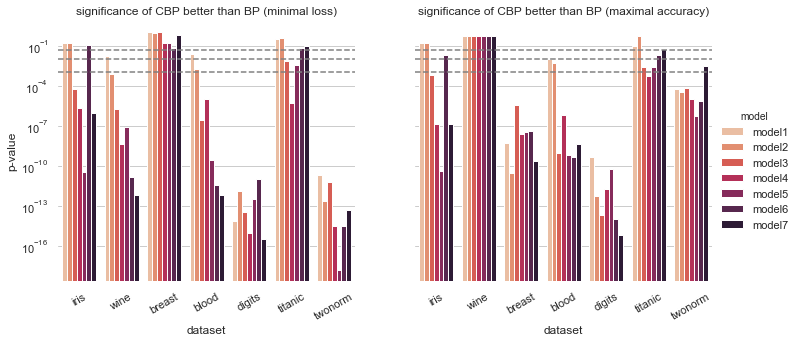

In [17]:
g = sns.catplot(x='dataset', y='p-value', hue='model', kind='bar', 
                col='metric', data=pv_df, palette='rocket_r',
                legend_out=True, height=5, aspect=1)
g.fig.subplots_adjust(wspace=0.2, bottom=0.2)
titles = ['significance of CBP better than BP (minimal loss)', 
          'significance of CBP better than BP (maximal accuracy)']
g.set(yscale='log').despine(left=True, bottom=True)
for i in range(2):
    ax = g.axes[0, i]
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(titles[i])
    for p in [0.05, 0.01, 0.001]:
        ax.axhline(y=p, ls='--', c='grey')
g.fig.savefig('results/toy/all_pvalue_barplot.png', dpi=300)

In [18]:
def plot_results_pvalue_hetmap(loss_pv_df, acc_pv_df, save=True):
    c = mpl.cm.get_cmap('Reds', 256)
    colors = c(np.linspace(0, 1, 256))
    newcolors = colors[::70, :][::-1]
    cmap = mpl.colors.ListedColormap(newcolors)
    bounds = [1e-4, 0.001, 0.01, 0.05, 0.1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=(6, 4.5))
    sns.heatmap(loss_pv_df, vmin=0, vmax=1, norm=norm, cmap=cmap,
                cbar_kws={'label': 'p value', 'extend': 'both',
                          'format': '%.0e'}, linewidths=2)
    ax.set_title('significance of CBP better than BP (minimal loss)')
    ax.tick_params(labelrotation=45)
    plt.tight_layout()
    if save:
        fig.savefig(f'results/toy/train_loss_pvalue.png', dpi=300)
        plt.close()
    else:
        plt.show()

    # acc_pv_df.fillna(.5, inplace=True)
    fig, ax = plt.subplots(figsize=(6, 4.5))
    sns.heatmap(acc_pv_df, vmin=0, vmax=1, norm=norm, cmap=cmap,
                cbar_kws={'label': 'p value', 'extend': 'both',
                          'format': '%.0e'}, linewidths=2)
    ax.set_title('significance of CBP better than BP (maximal accuracy)')
    ax.tick_params(labelrotation=45)
    plt.tight_layout()
    if save:
        fig.savefig(f'results/toy/train_acc_pvalue.png', dpi=300)
        plt.close()
    else:
        plt.show()

In [19]:
plot_results_pvalue_hetmap(df_loss, df_acc, save=True)

In [20]:
def count_pvalue(pv_list, ref_pv_list=[0.05, 0.01, 0.001]):
    pv_mat = np.array(pv_list)
    counts = [len(pv_mat)]
    for i, p in enumerate(ref_pv_list):
        counts.append(len(pv_mat[pv_mat <= p]))
    for i in range(len(ref_pv_list)):
        counts[i] = counts[i] - counts[i+1]
    return counts

In [21]:
loss_pv = pv_df[pv_df.metric=='loss'].loc[:,'p-value']
loss_sizes = count_pvalue(loss_pv)
acc_pv = pv_df[pv_df.metric=='acc'].loc[:,'p-value']
acc_sizes = count_pvalue(acc_pv)

In [22]:
def count_both_pvalue(pv_list1, pv_list2, ref_pv_list=[0.05, 0.01, 0.001]):
    counts_and = [len(pv_list1)]
    counts_or = [len(pv_list1)]
    for i, p in enumerate(ref_pv_list):
        n1 = 0
        n2 = 0
        for p1, p2 in zip(pv_list1, pv_list2):
            if p1 <= p and p2 <= p:
                n1 += 1
            if p1 <= p or p2 <= p:
                n2 += 1
        counts_and.append(n1)
        counts_or.append(n2)
    for i in range(len(ref_pv_list)):
        counts_and[i] = counts_and[i] - counts_and[i+1]
        counts_or[i] = counts_or[i] - counts_or[i+1]
    return counts_and, counts_or

In [23]:
sizes_and, sizes_or = count_both_pvalue(loss_pv, acc_pv)

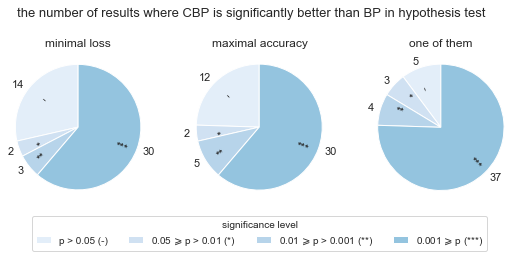

In [24]:
explode = (0., 0., 0., 0.)
labels = [r'p > 0.05 (-)',
          r'0.05 $\geqslant$ p > 0.01 (*)',
          r'0.01 $\geqslant$ p > 0.001 (**)',
          r'0.001 $\geqslant$ p (***)']
titles = ['minimal loss', 'maximal accuracy', 'one of them']
mycs = sns.color_palette('Blues', 9)[:4]

in_labels=['-', '*', '**', '***']
fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))
ax[0].pie(loss_sizes, explode=explode, labels=loss_sizes, startangle=90, colors=mycs)
ax[0].pie(loss_sizes, labels=in_labels, labeldistance=0.6, startangle=90,
          colors=mycs, rotatelabels=True)
wedges, _ = ax[1].pie(acc_sizes, explode=explode, labels=acc_sizes, startangle=90,
                      colors=mycs)
ax[1].pie(acc_sizes, labels=in_labels, labeldistance=0.6, startangle=90,
          colors=mycs, rotatelabels=True)
ax[2].pie(sizes_or, explode=explode, labels=sizes_or, startangle=90, colors=mycs)
ax[2].pie(sizes_or, labels=in_labels, labeldistance=0.6, startangle=90,
          colors=mycs, rotatelabels=True)
for i in range(3):
    ax[i].axis('equal')
    ax[i].set_title(titles[i], fontsize=12, pad=-20)
ax[1].legend(wedges, labels, title='significance level', loc='center',
             bbox_to_anchor=(-.25, -.05, 1.5, 0.05), ncol=4, fontsize=10,
             markerscale=1, title_fontsize=10, handlelength=1.5)
fig.subplots_adjust(bottom=0.1, top=0.9, wspace=.3)
fig.suptitle('the number of results where CBP is significantly better than BP in hypothesis test', fontsize=13)
fig.savefig('results/toy/all_pvalue_pie.png', dpi=300)
plt.show()